*This notebook was created by Svitozar Serkez, Andrei Trebushinin (andrei.trebushinin@xfel.eu) and Mykola Veremchuk. Source and license info is on [GitHub](https://github.com/ocelot-collab/ocelot). February 2020.*

## Tutorial on the radiation field propagation and grid resizing

In [23]:
%%javascript #for numbering equations
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

Here we give an easy way of derivation a free space propogator used in OCELOT code based on direct usage of the Maxwell equation.

\begin{align}
\nabla \times \vec{\mathbf{B}} -\, \frac1c\, \frac{\partial\vec{\mathbf{E}}}{\partial t} & = \frac{4\pi}{c}
\vec{\mathbf{j}} \\   \nabla \cdot \vec{\mathbf{E}} & = 4 \pi \rho \\
\nabla \times \vec{\mathbf{E}}\, +\, \frac1c\, \frac{\partial\vec{\mathbf{B}}}{\partial t} & = \vec{\mathbf{0}} \\
\nabla \cdot \vec{\mathbf{B}} & = 0
\end{align}

We start for the Helmholtz equation obtained be acting $\nabla \times$ operator on the $rot(\vec{H}) = -\cfrac{1}  {c}\cfrac{\partial{\vec{E}}}{\partial{t}}$ and sabstituting $\cfrac{\partial{\vec{E}}}{\partial{t}}$ from the other Maxwell equation. The derivation can be found in every lecture on clasical electrodinamic.

\begin{equation}
    c^2 \nabla^2 \vec{E} - \cfrac{\partial^2{\vec{E}}}{\partial{t}^2} = 0
    \label{eq:Fourier_rt}
\end{equation}

Here we give Fourier transform defenition for time-frequence domains

$\vec{\hat{E}}(\omega, x, y, z) = \mathcal{F_{\omega t}}[\vec{E}(t, x, y, z)] =  \displaystyle\int\limits_{-\infty}^{\infty} d\omega \vec{E}(t, x, y, z)\exp[i\omega t]$

$\vec{E}(t, x, y, z) = \mathcal{F_{\omega t}^{-1}}[\vec{\hat{E}}(\omega, x, y, z)]=  \cfrac{1}{2\pi} \displaystyle\int\limits_{-\infty}^{\infty} dt \vec{\hat{E}}(\omega, x, y, z)\exp[i\omega t]$

substituteng the last one and use Leibniz integral rule we obtain
\begin{equation}
    c^2 \nabla^2 \vec{E} + k_{0}^2{\vec{E}} = 0,
    \label{eq:Fourier_rw}
\end{equation}

where $k_0 = \omega/c$.

Fourier transform defenition for spacial domains

$\vec{\overline{E}}(\omega, k_x, k_y, z) = \mathcal{F_{kr}}[\vec{\hat{E}}(\omega, x, y, z)] =  \displaystyle\int\limits_{-\infty}^{\infty} dx dy\vec{\hat{E}}(\omega, x, y, z)\exp[ik_x x + ik_y y)]$

$\vec{\hat{E}}(\omega, x, y, z) = \mathcal{F_{kr}^{-1}}[\vec{\overline{E}}(\omega, k_x, k_y, z)]=  \cfrac{1}{(2\pi)^2} \displaystyle\int\limits_{-\infty}^{\infty} dxdy \vec{\hat{\overline{E}}}(\omega, k_x, k_y, z)\exp[-ik_x x - ik_y y)]$

\begin{equation}
   \cfrac{d^2\vec{\overline{E}}}{dz^2} + k_{0}^2\bigg(1 - \cfrac{k_x^2}{k_0^2} - \cfrac{k_y^2}{k_0^2} \bigg){\vec{\overline{E}}} = 0,
    \label{eq:Fourier_kw}
\end{equation}


solving the ordinary differential equation with inital condition ${\vec{\overline{E}}(\omega, k_x, k_y, 0)}$ we have

\begin{equation}
{\vec{\overline{E}}(\omega, k_x, k_y, z)} = {\vec{\overline{E}}(\omega, k_x, k_y, 0)}\exp{\bigg[ik_0z\bigg(1 - \cfrac{k_x^2}{k_0^2} - \cfrac{k_y^2}{k_0^2} \bigg)\bigg]}, 
\end{equation}

which is our solution for the wavefrom propogation problem.


next we will consider some aproximations and limitations

1) from the solution seen that there are not limitation on $k_x, k_y$

2) for the numerical simulation we can boost calculation leaving the field in time domain only, in such a way we reducing number of Fourier transforms needed for an itteration. 

but we assume no angular dispersion (true for plain FEL radiation) and

assume narrow spectrum at center of xlamds (true for plain FEL radiation) in other words we expect the field to be

$\vec{\hat{E}}(\omega, x, y, z) = \vec{\hat{E}}_0(x, y, z)\delta{(\omega - \omega_0)}$ where $\omega_0$ is a carrier frequency.

for the full simulations we can handel wide spectrum e.g. every slice in freq.domain is propagated according to its frequency

Below, we present the sceleton of the wave front propagation function. 

In [1]:
import logging
import ocelot
from ocelot.common.globals import *
from ocelot.optics.new_wave import *
from ocelot.gui.dfl_plot import plot_dfl, plot_wigner
from copy import deepcopy

from ocelot import ocelog
ocelog.setLevel(logging.WARNING)
ocelog.setLevel(logging.DEBUG)
ocelog.setLevel(logging.INFO)

initializing ocelot...


In [2]:

E_pohoton = 1239.8 #central photon energy [eV]
xlamds = h_eV_s * speed_of_light / E_pohoton
kwargs={'xlamds':(h_eV_s * speed_of_light / E_pohoton), #[m] - central wavelength
        'rho':1.0e-4, 
        'shape':(101,101,1),             #(x,y,z) shape of field matrix (reversed) to dfl.fld
        'dgrid':(400e-5,400e-5,35e-6), #(x,y,z) [m] - size of field matrix
        'power_rms':(25e-5,25e-5,10e-6),#(x,y,z) [m] - rms size of the radiation distribution (gaussian)
        'power_center':(0,0,None),     #(x,y,z) [m] - position of the radiation distribution
        'power_angle':(0,0),           #(x,y) [rad] - angle of further radiation propagation
        'power_waistpos':(0,0),        #(Z_x,Z_y) [m] downstrean location of the waist of the beam
        'wavelength':None,             #central frequency of the radiation, if different from xlamds
        'zsep':None,                   #distance between slices in z as zsep*xlamds
        'freq_chirp':0,                #dw/dt=[1/fs**2] - requency chirp of the beam around power_center[2]
        'en_pulse':None,                #total energy or max power of the pulse, use only one
        'power':1e6,
        }

dfl = RadiationField()
grid = Grid()
dfl = generate_gaussian_dfl(**kwargs);  #Gaussian beam defenition
grid.copy_grid(dfl)
#plot_dfl(dfl)
#dfl.shape
dfl.shape()


[INFO    ] generating radiation field of shape (nz,ny,nx): (101, 101, 1)


(1, 101, 101)

In [3]:
### the skeleton for propagation function
z0 = 100 #the distance of propagation 
domains='kt' # or 'kt' --- in which domain propogarion will be applied
orig_domains=dfl.domains()

if domains in ['kf', 'kt']:
    dfl.to_domain(domains) #transform the field to the desired domain
else:
    raise ValueError("domains value should be 'kf' or 'kt' or 'k'")

In [4]:
k_x, k_y = np.meshgrid(dfl.grid_kx(), dfl.grid_ky()) # the grid for the point spread function

if dfl.domain_z is 'f':
    k = dfl.grid_kz()
    H = [np.exp(1j * z0 * (np.sqrt(k[i] ** 2 - k_x ** 2 - k_y ** 2) - k[i])) for i in range(dfl.Nz())] #H = exp(iz0(k^2 - kx^2 - ky^2)^(1/2) - k)
else:
    k = 2 * np.pi / dfl.xlamds
    H = [np.exp(1j * z0 * (np.sqrt(k ** 2 - k_x ** 2 - k_y ** 2) - k)) for i in range(dfl.Nz())]  #H = exp(iz0(k^2 - kx^2 - ky^2)^(1/2) - k)

[INFO    ] plotting radiation field (dfl)
[WARNING ] : "scale_x" will be deprecated, use "grid_x and grid_kx" instead (new_wave.py:429)
[WARNING ] : : "scale_kx" will be deprecated, use "grid_x and grid_kx" instead (new_wave.py:402)
[WARNING ] : : "scale_ky" will be deprecated, use "grid_y and grid_ky" instead (new_wave.py:411)
/home/andrei/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/home/andrei/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/home/andrei/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3215: MatplotlibDeprecationWarning: 
The `xmin` argument was deprecated in

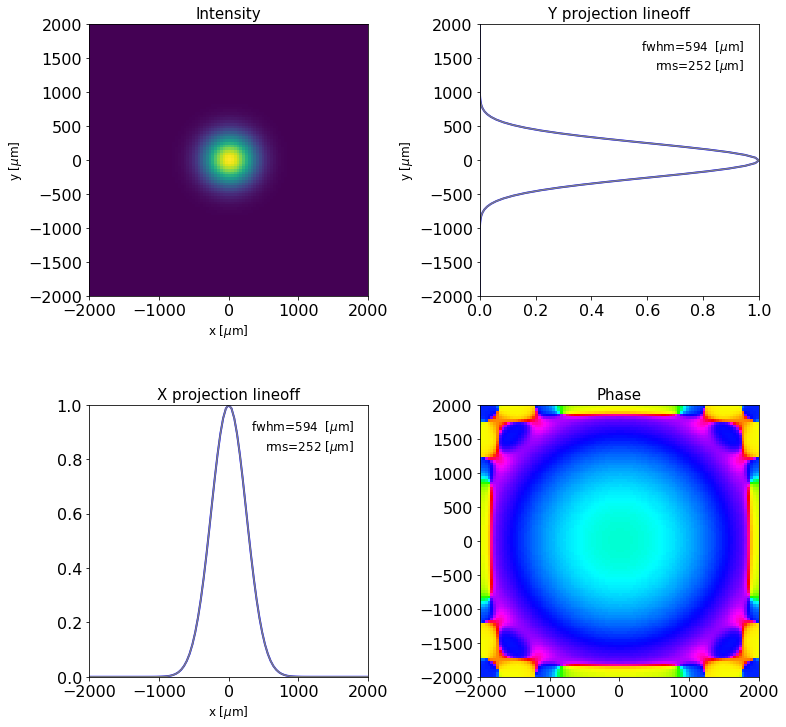

In [5]:
dfl.fld = dfl.fld*H
dfl.to_domain(orig_domains)
plot_dfl(dfl)

In [6]:
import logging
import ocelot
from ocelot.common.globals import *
from ocelot.optics.new_wave import *
from ocelot.gui.dfl_plot import plot_dfl, plot_wigner
from copy import deepcopy

from ocelot import ocelog
ocelog.setLevel(logging.WARNING)
ocelog.setLevel(logging.DEBUG)
ocelog.setLevel(logging.INFO)

[INFO    ] imitating SASE radiation
[INFO    ] : generating radiation field of shape (nz,ny,nx): (51, 51, 100)
[WARNING ] : : "scale_kz" will be deprecated, use "grid_z and grid_kz" instead (new_wave.py:420)
[INFO    ] : generating 1d radiation field imitating SASE
[INFO    ] : plotting radiation field (dfl)
[WARNING ] : : : "scale_kz" will be deprecated, use "grid_z and grid_kz" instead (new_wave.py:420)
[WARNING ] : : "scale_x" will be deprecated, use "grid_x and grid_kx" instead (new_wave.py:429)
[WARNING ] : : : "scale_kx" will be deprecated, use "grid_x and grid_kx" instead (new_wave.py:402)
[WARNING ] : : : "scale_ky" will be deprecated, use "grid_y and grid_ky" instead (new_wave.py:411)


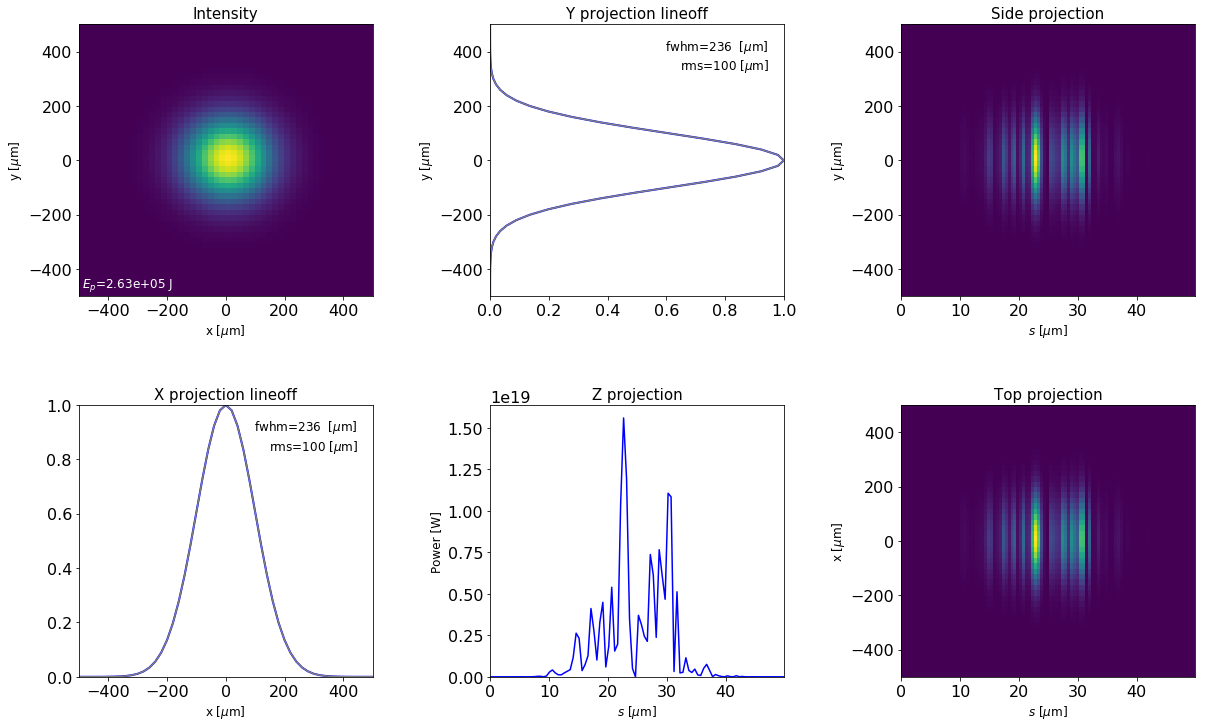

In [9]:
E_pohoton = 1239.8 #central photon energy [eV]
xlamds = h_eV_s * speed_of_light / E_pohoton

SASE_dfl = imitate_sase_dfl(xlamds)
plot_dfl(SASE_dfl)